# Introduction to Image Convolution

1. dot product
2. dot product of 2D data
3. cross-correlation = a 2D result of dot products
4. convolution == 2D linear filter
    1. Smoothing
    1. Edge Detection: Sobel Operator
7. Nonlinear edge detection, Canny edge detector

In [34]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import torch
from torch import nn
from d2l import torch as d2l

## 1. Dot Product

$ a = x \cdot y $, $a \in \mathbb{R}$

## 2. dot product of 2D vectors

$
a = x \cdot y
$

## 3. Cross-Correlation (Convolution in CNN)

1. kernel matrix (2D)
2. source matrix (2D)
3. scan and dot product
4. construct output 2D image

## 4. Convolution as 2D linear filter

* Ref: https://docs.opencv.org/3.4/d4/d13/tutorial_py_filtering.html

1. Box filter for smoothing
$
    W = \frac{1}{9} [ [1, 1, 1], [1, 1, 1], [1, 1, 1]]  \in \mathbb{R}^2
$


2. A derivative filter for gradient approximation
$
    W = [ [-1, -2, 1], [0, 0, 0], [1, 2, 1]]  \in \mathbb{R}^2
$

$
    S = I * W
$

(256, 256, 3)


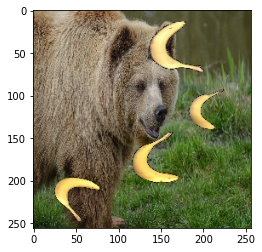

In [61]:
img = cv2.imread("../img/banana.jpg")
img = img[:,:,::-1]  # BGR -> RGB
print(img.shape)
plt.imshow(img);  # plt is for RGB display

(256, 256, 3) uint8


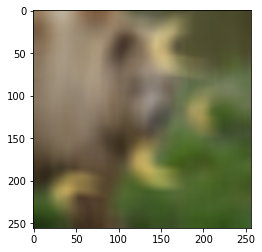

In [36]:
kernel = np.ones((25, 25), np.float32)

kernel /= kernel.shape[0]*kernel.shape[1]  # 25x25

smoothed = cv2.filter2D(img, -1, kernel)  # applies conv2d to each channel & combine
print(smoothed.shape, smoothed.dtype)
plt.imshow(smoothed);

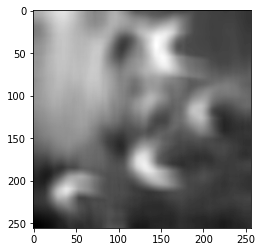

In [37]:
plt.imshow(smoothed[:,:,0], cmap='gray');  # red channel

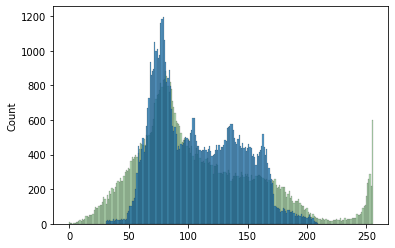

In [38]:
sns.histplot(img[:,:,0].reshape(-1), discrete=True, color='g', alpha=.3);
sns.histplot(smoothed[:,:,0].reshape(-1), discrete=True);

### PyTorch

- pytorch is aimed to compute the kernel parameters, but here we see its computation only.

In [102]:
conv2d = nn.Conv2d(in_channels=1, 
                   out_channels=1, 
                   kernel_size=25, padding=25//2)
print(conv2d.weight.shape)
conv2d.weight.data[0,0,:2, :3]  # some of the weights

torch.Size([3, 1, 25, 25])


tensor([[-0.0019, -0.0233,  0.0361],
        [-0.0088,  0.0107, -0.0014]])

In [40]:
conv2d.weight[:,:,:2,:3]

tensor([[[[-0.0004,  0.0299,  0.0181],
          [ 0.0148,  0.0371,  0.0310]]]], grad_fn=<SliceBackward>)

In [41]:
# copy the kernel into the weight of conv2d
for i in range(len(kernel)):
    for j in range(len(kernel[0])):
        conv2d.weight.data[0,0, i, j] = torch.tensor(kernel[i,j])

In [42]:
conv2d.weight[:,:,:2,:3]

tensor([[[[0.0016, 0.0016, 0.0016],
          [0.0016, 0.0016, 0.0016]]]], grad_fn=<SliceBackward>)

In [43]:
# Here, we consider 1 channel image only; multi channel image comes later
# batch x channel x height x width
batch_im = img[:,:,0].reshape(1, 1, 256,256) 
batch_im = torch.FloatTensor(batch_im)
print(batch_im.shape, batch_im.dtype)

torch.Size([1, 1, 256, 256]) torch.float32


torch.Size([1, 1, 256, 256]) torch.float32


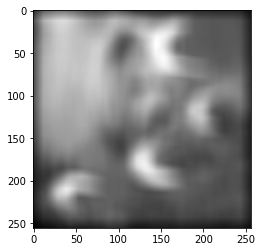

In [44]:
# just check the output shape
with torch.no_grad():  # we do not gradient here
    convout = conv2d (batch_im)

print(convout.shape, convout.dtype)
convout_im = convout.numpy()
convout_im = convout_im.reshape(256, 256)
plt.imshow(convout_im, cmap='gray');

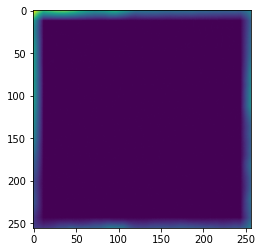

In [45]:
diff = np.abs(smoothed[:,:,0] - convout_im)
plt.imshow(diff); #, cmap='gray');

- The same results except for the boundary pixels
- PyTorch is to learn the kernel parameters, not to perform a pre-defined convolution operation.
- How to learn? Through SGD.
    - Supervised learning.

### Sobel Operator

- Gradient computation

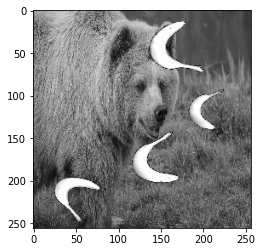

In [46]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
im = hsv[:,:,2].astype(np.float32)  # image brightness only
plt.imshow(im, 'gray');

(256, 256)


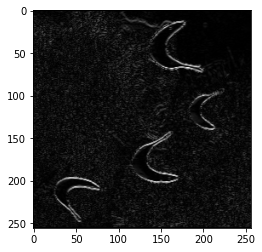

In [47]:
kernel_y = np.array([ [-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
grad_y = cv2.filter2D(im, -1, kernel_y,)  # applies conv2d to each channel & combine
print(grad_y.shape)
gabsy = np.abs(grad_y)
gabsy = gabsy / gabsy.max()
plt.imshow(gabsy, cmap='gray');

In [48]:
grad_y.min(), grad_y.max()+1

(-977.0, 963.0)

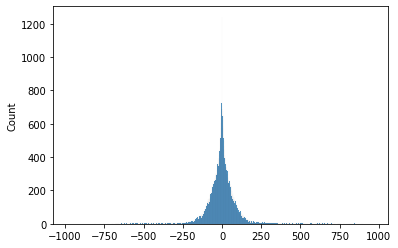

In [49]:
sns.histplot(grad_y.reshape(-1), discrete=True);

(256, 256) -890.0 781.0


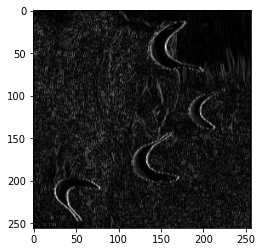

In [50]:
kernel_x = kernel_y.T  # x direction
grad_x = cv2.filter2D(im, -1, kernel_x)  # applies conv2d to each channel & combine
print(grad_x.shape, grad_x.min(), grad_x.max())
gabsx = np.abs(grad_x)
gabsx = gabsx / gabsx.max()
plt.imshow(gabsx, cmap='gray');

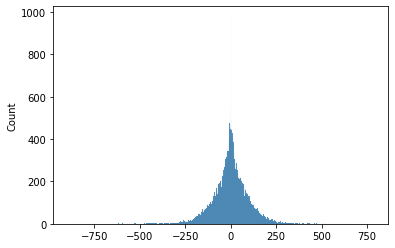

In [51]:
sns.histplot(grad_x.reshape(-1), discrete=True);

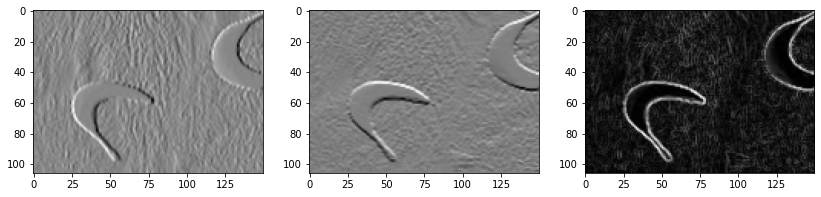

In [52]:
gabs = gabsx + gabsy 

fig, axes = plt.subplots(1,3, figsize=(14,4))
for ax, im in zip(axes, [grad_x, grad_y, gabs]):
    ax.imshow(im[150:, :150], cmap='gray')
    ax.set(title='')

## Canny Operator
- Ref: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

- Edge map generation algorithm
    - binary edge map of single pixel width

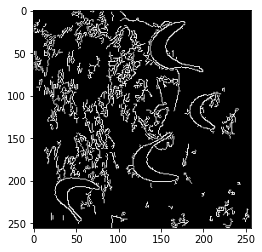

In [53]:
lowerTh = 130
edge_canny = cv2.Canny(img[:,:,0], threshold1=lowerTh, threshold2=3*lowerTh) # red channel
plt.imshow(edge_canny, cmap="gray");

## Multi-Channel Convolution by Pytorch Conv2d

- Up to now, convolution kernel is of shape $H\times W$
- In CNN, a conv kernel in general is of shape $C\times H \times W$

In [54]:
conv2d = nn.Conv2d(in_channels=3, # input source is of 3 channel (eg. RGB or HSV); it can be of N >= 1 channel.
                   out_channels=1, # We define only one 3xHxW conv. kernel
                   kernel_size=25, # H & W
                   padding=25//2   # to keep the output shape the same as input
                   )
print(conv2d.weight.shape)
conv2d.weight.data[0,0,:2, :3]  # some of the weights

torch.Size([1, 3, 25, 25])


tensor([[-0.0109,  0.0109,  0.0192],
        [-0.0228, -0.0157, -0.0078]])

In [58]:
# copy the kernel into the weight of conv2d
wn = conv2d.weight.shape[1]*conv2d.weight.shape[2]*conv2d.weight.shape[3]
print('weight normalization factor: ', wn)

for c in range(3):
    for i in range(25):
        for j in range(25):
            conv2d.weight.data[0,c, i, j] = torch.tensor(1./wn)

weight normalization factor:  1875


In [59]:
conv2d.weight[:,:,:2,:3]

tensor([[[[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]],

         [[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]],

         [[0.0005, 0.0005, 0.0005],
          [0.0005, 0.0005, 0.0005]]]], grad_fn=<SliceBackward>)

In [73]:
# Here, we consider 1 channel image only; multi channel image comes later
# batch x channel x height x width
im_in = img.copy()
print(im_in.shape)
batch_im = torch.tensor(im_in,dtype=torch.float32)
batch_im = batch_im.unsqueeze(0)       # HWC -> BHWC
print(batch_im.shape, batch_im.dtype)  # BHWC
batch_im = batch_im.permute(0,3,1,2)
print(batch_im.shape, batch_im.dtype)  # BCHW
batch_im /= 255.                       # better convergence and numerical stability

(256, 256, 3)
torch.Size([1, 256, 256, 3]) torch.float32
torch.Size([1, 3, 256, 256]) torch.float32


torch.Size([1, 1, 256, 256]) torch.float32


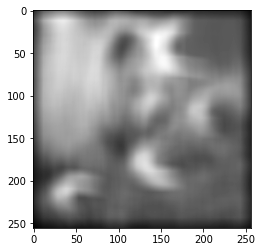

In [72]:
# just check the output shape
with torch.no_grad():  # we do not gradient here
    convout = conv2d (batch_im)

print(convout.shape, convout.dtype)
convout_im = convout.numpy()
convout_im = convout_im.reshape(256, 256)
plt.imshow(convout_im, cmap='gray');

In [99]:
import torchvision
toTensor = torchvision.transforms.ToTensor()
im_t = toTensor(im_in)
print('after toTensor(): ', im_t.shape)

after toTensor():  torch.Size([3, 256, 256])


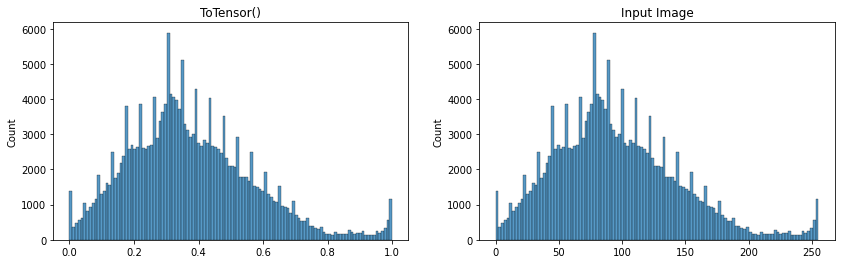

In [100]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
sns.histplot(im_t.numpy().reshape(-1), ax=axes[0]); axes[0].set(title='ToTensor()')
sns.histplot(im_in.reshape(-1), ax=axes[1]); axes[1].set(title='Input Image');

torch.Size([1, 3, 256, 256])
conv out: torch.Size([1, 1, 256, 256])


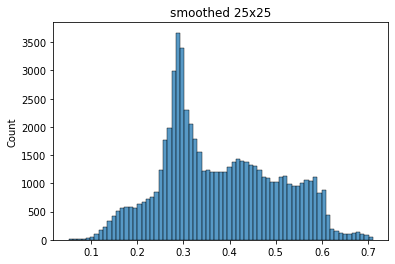

In [101]:
im_t = im_t.unsqueeze(0); print(im_t.shape)
with torch.no_grad():
    sm_t = conv2d(im_t)
    print('conv out:', sm_t.shape)

ax = sns.histplot(sm_t.numpy().reshape(-1)); ax.set(title='smoothed 25x25');

# Assignment: Learning a smoothing filter

1. Use random initialization for `torch.conv2d(filter_size=25, in_channels=1, out_channels=1);` meaning that you don't change the weight.
2. Compute three pairs of `(im, smoothed)` from each of RGB channels. This gives us 3 data points.
3. Train the network so that the output of `conv2d` may produce the box filter.
1. `MSELoss()` or `L1Loss` can be used. When `(smoothed, predicted)` pair is supplied to the loss function, get rid of the boundary pixsels (even though you may use them all) because they do not belong to the pixels of main computation.

4. Can you do the same thing for Canny edge detection?